In [1]:
import string
import os
from os import listdir, mkdir
from pickle import dump, load
import zhon.hanzi
import jieba

import numpy as np
from numpy import array, argmax

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, TimeDistributed, Lambda
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from keras.callbacks import ModelCheckpoint
import keras.backend as K

from nltk.translate.bleu_score import corpus_bleu
from kulc.attention import ExternalAttentionRNNWrapper

Using TensorFlow backend.
/root/anaconda3/envs/myconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/root/anaconda3/envs/myconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/root/anaconda3/envs/myconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/root/anaconda3/envs/myconda/lib/pytho

# VGG提取图片特征

In [2]:
def extract_features(directory):
    # 去除最后一层，因为目的不是分类，而是特征抽取
    in_layer = Input(shape=(224, 224, 3))
    model = VGG16(include_top=False, input_tensor=in_layer)
    model.summary()
    
    # 每张图片抽取特征
    features = dict()
    for name in listdir(directory):
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))
        # 将像素转存为数组形式
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # VGG的函数，预处理并预测
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        #存储图片特征
        image_id = name.split('.')[0]
        features[image_id] = feature
        # print('>%s' % name)
    return features

features,model2 = extract_features('Data/Images')
print('Extracted Features: %d' % len(features))

if not os.path.exists('MiddleFiles'):
    mkdir('MiddleFiles')
dump(features, open('MiddleFiles/features.pkl', 'wb'))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# 提取文本信息

In [3]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# 用字典存储标题-语句信息
def load_descriptions(doc):
    mapping = dict()
    for line in doc.split('\n'):
        if not line:
            continue
        # 以空格分隔
        tokens = line.split()
        # 第一个是图片标题，后面的是描述语句
        image_id, image_desc = tokens[0], tokens[1]
        if image_id[-1] != '0':
            continue
        # 去除.jpg的后缀
        image_id = image_id.split('.')[0]
        #以字典形式存储
        mapping[image_id] = image_desc
    return mapping

#保存文件
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc in descriptions.items():
        lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()


doc = load_doc('Data/Captions/flickr8kzhc.caption.txt')

# 加载描述语句
descriptions = load_descriptions(doc)
print('Loaded: %d' % len(descriptions))

# 保存文件
if not os.path.exists('MiddleFiles'):
    mkdir('MiddleFiles')
save_descriptions(descriptions, 'MiddleFiles/descriptions.txt')

Loaded: 8091


# 加载数据集

In [4]:
# 获取训练集的图片名称
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    for line in doc.split('\n'):
        # 可能有空行
        if not line:
            continue
        dataset.append(line)
    return set(dataset)

# 根据图片名称加载描述语句
def load_clean_descriptions(filename, dataset):
    punctuations = string.punctuation + zhon.hanzi.punctuation
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        if not line:
            continue
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1]
        image_desc = jieba.cut(image_desc)
        image_desc = [word for word in image_desc if word not in punctuations]
        
        # 描述语句首尾加开始/终止词，用于序列输入
        image_desc.insert(0, 'startseq')
        image_desc.append('endseq')
        
        # 跳过不在训练集中的图片
        if image_id in dataset:
            descriptions[image_id] = image_desc
    return descriptions

# 根据图片名称加载图片的特征向量
def load_photo_features(filename, dataset):
    all_features = load(open(filename, 'rb'))
    features = {k: all_features[k].reshape(1, 49, 512) for k in dataset}
    return features


#加载图片名称
image_ids_train = load_set('Data/Partition/flickr8ktrain.txt')
image_ids_val = load_set('Data/Partition/flickr8kval.txt')
image_ids_test = load_set('Data/Partition/flickr8ktest.txt')

image_ids = set.union(image_ids_train,image_ids_val)

print('Dataset: %d' % len(image_ids_train))

#通过图片名称得到图片的描述语句
descriptions_train = load_clean_descriptions('MiddleFiles/descriptions.txt', image_ids_train)
print('Descriptions_train: %d' % len(descriptions_train))

descriptions_val = load_clean_descriptions('MiddleFiles/descriptions.txt', image_ids_val)
print('Descriptions_val: %d' % len(descriptions_val))

descriptions = load_clean_descriptions('MiddleFiles/descriptions.txt', image_ids)
print('Descriptions: %d' % len(descriptions))


#通过图片名称得到图片的特征向量
features_train = load_photo_features('MiddleFiles/features.pkl', image_ids_train)
print('Photos_train: %d' % len(features_train))

#通过图片名称得到图片的特征向量
features_val = load_photo_features('MiddleFiles/features.pkl', image_ids_val)
print('Photos_val: %d' % len(features_val))

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache


Dataset: 6000


Loading model cost 0.878 seconds.
Prefix dict has been built successfully.


Descriptions_train: 6000
Descriptions_val: 1000
Descriptions: 7000
Photos_train: 6000
Photos_val: 1000


# 创建单词映射与序列

In [5]:
# 建立分词器tokenizer
def create_tokenizer(descriptions):
    lines = list(descriptions.values())
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

def one_hot_encode(data, MAXIMUM_CAPTION_LENGTH, n_classes):
    result = np.zeros((len(data), MAXIMUM_CAPTION_LENGTH, n_classes))
    for i, item in enumerate(data):
        a = 0
        for j, word in enumerate(item):
            result[i, j, word] = 1.0
            a = j
        for k in range(a+1, MAXIMUM_CAPTION_LENGTH):
            result[i, k, 0] = 1.0
    return result

def data_generator(batch_size, captions, get_image, tokenizer, max_length, vocab_size):
    n_steps = int(np.ceil(len(captions) / batch_size))
    while True:
        for i in range(n_steps):
            if i < n_steps - 1:
                batch_indices = np.arange(i, i + batch_size)
            else:
                batch_indices = np.arange(64 * (n_steps - 1), len(captions))
        
            L = list(captions.keys())

            batch_image_features = np.empty((len(batch_indices), 7*7, 512))
            for i, j in enumerate(batch_indices):
                batch_image_features[i] = get_image[L[j]].reshape((7*7, 512))

            batch_captions1 = [captions[L[item]][:-1] for item in batch_indices]
            batch_captions2 = [captions[L[item]][1:] for item in batch_indices]

            input_captions = tokenizer.texts_to_sequences(batch_captions1)
            output_captions = tokenizer.texts_to_sequences(batch_captions2)

            input_captions = pad_sequences(input_captions, maxlen= max_length, padding='post')
            output_captions = one_hot_encode(output_captions, max_length, vocab_size)
       
            batch_image_features = np.array(batch_image_features, dtype=np.float32)

            x_data = [batch_image_features,input_captions, 
                      np.zeros([input_captions.shape[0], unit_size]), np.zeros([input_captions.shape[0], unit_size])]
            y_data = output_captions

            yield (x_data, y_data)


#输出所有语句不同的单词总数
tokenizer = create_tokenizer(descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

#输出单个语句最大长度
max_length = max([len(desc) for desc in descriptions.values()])
print('Description Length: %d' % max_length)

Vocabulary Size: 2260
Description Length: 20


# 模型定义与训练

In [6]:
def define_model(vocab_size, max_length):
    
    # 以下是图片特征提取层
    inputs1 = Input(shape=(49, 512))
    image_features = TimeDistributed(Dense(512, activation="relu"))(inputs1)
    
    # 以下是文本特征提取层
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256)(inputs2)
    
    #以下是attention层
    averaged_image_features = Lambda(lambda x: K.mean(x, axis=1))
    averaged_image_features = averaged_image_features(inputs1)
    initial_state_h = Dense(256)(averaged_image_features)
    initial_state_c = Dense(256)(averaged_image_features)
    
    encoder = LSTM(256, return_sequences=True, return_state=True, recurrent_dropout=0.1)
    attented_encoder = ExternalAttentionRNNWrapper(encoder, return_attention=True)
    output = TimeDistributed(Dense(vocab_size, activation="softmax"), name="output")
    attented_encoder_training_data, _, _ , _= attented_encoder([se1,image_features], initial_state=[initial_state_h, initial_state_c])
    training_output_data = output(attented_encoder_training_data)
    
    model = Model(inputs=[inputs2, inputs1], outputs=training_output_data)
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
    
    # 模型描述与绘制
    model.summary()
    # plot_model(model, to_file='model.png', show_shapes=True)
    return model

model = define_model(vocab_size, max_length)

# 保存模型
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=True)

steps = len(descriptions)
batch_size = 64

# create the data generator
generator = data_generator(batch_size, descriptions_train, features_train, tokenizer, max_length, vocab_size)
validation_generator = data_generator(batch_size, descriptions_val, features_val, tokenizer, max_length, vocab_size)

# fit for one epoch
history = model.fit_generator(generator, epochs=30, validation_data=validation_generator,
                              validation_steps=int(np.ceil(len(descriptions_val) / batch_size)),
                              steps_per_epoch=int(np.ceil(len(descriptions_train) / batch_size)), verbose=1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 49, 512)      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512)          0           input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 20, 256)      578560      input_3[0][0]                    
__________________________________________________________________________________________________
time_distr

# 模型评价

In [34]:
# 数字映射到单词
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# 把模型预测转换成语句
def generate_desc(model, tokenizer, photo, max_length): ## 需要修改!!!!!
    in_text = 'startseq'
    # 模型每次生成一个单词，直到endseq停止
    for i in range(max_length-1):
        # 把上一个循环为止生成的所有单词构成序列
        intext = in_text.split()
        sequence = tokenizer.texts_to_sequences([intext])[0]
        # 填充剩余部分，让序列长度为maxlength
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        # 输入模型，预测下一个单词
        yhat = model.predict([sequence,photo], verbose=0)[0][i+1]
        yhat[0] = 0            #去掉停止词
        # 选择概率最高的为下一个单词
        yhat = yhat.argmax()
        word = word_for_id(yhat, tokenizer)
        
        # 无法预测，停止
        if word is None:
            break
        # 逐步添加单词
        in_text +=' '+  word
        # 遇到结尾词，停止
        if word == 'endseq':
            break
    return in_text[10:len(in_text)]

def inference(image_features, plot_attention):
    image_features = np.array([image_features])
    state_h, state_c = initial_state_inference_model.predict(image_features)

    caption = [le.transform_word("<START>")]
    attentions = []

    current_word = None
    for t in range(MAXIMUM_CAPTION_LENGTH):
        caption_array = np.array(caption).reshape(1, -1)
        output, state_h, state_c, attention = inference_model.predict([image_features, caption_array, state_h, state_c])
        attentions.append(attention[0, -1].reshape((14, 14)))

        current_word = np.argmax(output[0, -1])
        caption.append(current_word)

        if current_word == le.transform_word("<STOP>"):
            break
    sentence = [le._index_word_map[i] for i in caption[1:]]

    if plot_attention:
        print(len(attentions))
        x = int(np.sqrt(len(attentions)))
        y = int(np.ceil(len(attentions) / x))
        _, axes = plt.subplots(y, x, sharex="col", sharey="row")
        axes = axes.flatten()
        for i in range(len(attentions)):
            atn = skimage.transform.pyramid_expand(attentions[i], upscale=16, sigma=20)
            axes[i].set_title(sentence[i])
            axes[i].imshow(atn, cmap="gray")

        plt.show()

    return " ".join(sentence) + " ({0})".format(len(caption)-1)



#模型BLEU分数计算
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    cout=0
    for key, desc_list in descriptions.items():
        # yhat为模型的输出语句
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # references使实际的描述语句
        references = [d.split() for d in desc_list]
        
        actual.append(references)
        predicted.append(yhat.split())
        
    # 计算BLEU分数
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

#evaluate_model(model, descriptions, features, tokenizer, max_length)

In [35]:
# save the tokenizer
dump(tokenizer, open('MiddleFiles/tokenizer.pkl', 'wb'))

In [39]:
# load the tokenizer
# tokenizer = load(open('tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 20

# extract features from each photo in the directory
def extract_features(filename):
    
    in_layer = Input(shape=(224, 224, 3))
    cnn_model = VGG16(include_top=False, input_tensor=in_layer)
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = cnn_model.predict(image, verbose=0)
    feature=feature.reshape(1,49,512)
    return feature

# load and prepare the photograph
photo = extract_features('Data/Images/96973080_783e375945.jpg')
description = generate_desc(model, tokenizer, photo, max_length)
description

'startseq 狗 雪地 里 奔跑 接球 endseq'

['startseq', '一只', '狗', '在', '雪地', '里', '奔跑', 'endseq']

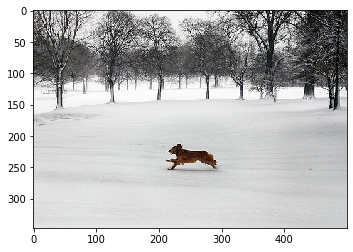

In [41]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image_file_dir = 'Data/Images/96973080_783e375945.jpg'

# 展示图片
img = mpimg.imread(image_file_dir)
plt.imshow(img)
#真实标签
descriptions['96973080_783e375945']